In [1]:
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import FashionMNIST
from torch.utils.data import DataLoader

transform = Compose(
    [
        ToTensor(),
        Lambda(lambda x: (x - 0.5) * 2),
    ]
)
dataset = FashionMNIST(
    "./datasets", download=True, train=True, transform=transform
)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [2]:
import torch
import torch.nn as nn


class AutoEncoderBlock(nn.Module):
    def __init__(
        self,
        shape,
        in_channel,
        out_channel,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=None,
        normalize=True,
    ):
        super().__init__()
        self.layer_norm = nn.LayerNorm(shape)
        self.conv_1 = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding)
        self.conv_2 = nn.Conv2d(out_channel, out_channel, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.layer_norm(x) if self.normalize else x
        out = self.conv_1(out)
        out = self.activation(out)
        out = self.conv_2(out)
        out = self.activation(out)
        return out
    
    
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # layer 1
        self.layer_1_block = nn.Sequential(
            AutoEncoderBlock(shape=(1, 28, 28), in_channel=1, out_channel=10),
            AutoEncoderBlock(shape=(10, 28, 28), in_channel=10, out_channel=10),
            AutoEncoderBlock(shape=(10, 28, 28), in_channel=10, out_channel=10),
        )
        self.layer_1_down = nn.Conv2d(10, 10, 4, 2, 1)
        # layer 2
        self.layer_2_block = nn.Sequential(
            AutoEncoderBlock(shape=(10, 14, 14), in_channel=10, out_channel=20),
            AutoEncoderBlock(shape=(20, 14, 14), in_channel=20, out_channel=20),
            AutoEncoderBlock(shape=(20, 14, 14), in_channel=20, out_channel=20),
        )
        self.layer_2_down = nn.Conv2d(20, 20, 4, 2, 1)

        # layer 3
        self.layer_3_block = nn.Sequential(
            AutoEncoderBlock(shape=(20, 7, 7), in_channel=20, out_channel=40),
            AutoEncoderBlock(shape=(40, 7, 7), in_channel=40, out_channel=40),
            AutoEncoderBlock(shape=(40, 7, 7), in_channel=40, out_channel=40),
        )
        self.layer_3_down = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1), nn.SiLU(), nn.Conv2d(40, 40, 4, 2, 1)
        )

    def forward(self, x):
        # encoding
        out_1_block_result = self.layer_1_block(x)  # (N, 10, 28, 28)
        out_1_down_result = self.layer_1_down(out_1_block_result)  # (N, 10, 14, 14)
        out_2_block_result = self.layer_2_block(out_1_down_result)  # (N, 20, 14, 14)
        out_2_down_result = self.layer_2_down(out_2_block_result)  # (N, 20, 7, 7)
        out_3_block_result = self.layer_3_block(out_2_down_result)  # (N, 40, 7, 7)
        out_3_down_result = self.layer_3_down(out_3_block_result)  # (N, 40, 3, 3)
        return out_3_down_result
    
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # layer 4
        self.layer_4_up = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
        )

        self.layer_4_block = nn.Sequential(
            AutoEncoderBlock(shape=(40, 7, 7), in_channel=40, out_channel=40),
            AutoEncoderBlock(shape=(40, 7, 7), in_channel=40, out_channel=20),
            AutoEncoderBlock(shape=(20, 7, 7), in_channel=20, out_channel=20),
        )

        # layer 5
        self.layer_5_up = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.layer_5_block = nn.Sequential(
            AutoEncoderBlock(shape=(20, 14, 14), in_channel=20, out_channel=20),
            AutoEncoderBlock(shape=(20, 14, 14), in_channel=20, out_channel=10),
            AutoEncoderBlock(shape=(10, 14, 14), in_channel=10, out_channel=10),
        )

        # layer 6
        self.layer_6_up = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.layer_6_block = nn.Sequential(
            AutoEncoderBlock(shape=(10, 28, 28), in_channel=10, out_channel=10),
            AutoEncoderBlock(shape=(10, 28, 28), in_channel=10, out_channel=10),
            AutoEncoderBlock(
                shape=(10, 28, 28), in_channel=10, out_channel=10, normalize=False
            ),
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, z):
        # decoding
        out_4_up_result = self.layer_4_up(z)  # (N, 40, 7, 7)
        out_4_block_result = self.layer_4_block(out_4_up_result)  # (N, 20, 7, 7)
        out_5_up_result = self.layer_5_up(out_4_block_result)  # (N, 20, 14, 14)
        out_5_block_result = self.layer_5_block(out_5_up_result)  # (N, 10, 14, 14)
        out_6_up_result = self.layer_6_up(out_5_block_result)  # (N, 10, 28, 28)
        out_6_block_result = self.layer_6_block(out_6_up_result)  # (N, 10, 28, 28)
        out = self.conv_out(out_6_block_result)  # (N, 1, 28, 28)
        return out

In [3]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.mu_layer = nn.Linear(360, 32)
        self.logvar_layer = nn.Linear(360, 32)
        self.reparam_layer = nn.Linear(32, 360)
        self.decoder = Decoder()

    def reparameterize(self, z):
        # flatten
        z = z.view(z.size()[0], -1)  # (N, 360)

        # reparameterize
        mu = self.mu_layer(z)  # (N, 32)
        logvar = self.logvar_layer(z)  # (N, 32)
        sigma = torch.randn_like(logvar)  # (N, 32)
        z = mu + logvar * sigma  # (N, 32)
        z = self.reparam_layer(z)  # (N, 360)

        # unflatten
        z = z.view(x.size()[0], 40, 3, 3)  # (N, 40, 3, 3)
        return z, mu, logvar

    def forward(self, x):
        # encode
        z = self.encoder(x)  # (N, 40, 3, 3)
        # reparameterize
        z, _, _ = self.reparameterize(z)
        # decode
        recon_x = self.decoder(z)
        return recon_x


In [4]:
vae = VariationalAutoEncoder()

In [5]:
for batch in loader:
    x = batch[0]
    break

with torch.no_grad():
    # encode
    z = vae.encoder(x)  # (N, 40, 3, 3)
    
    # flatten
    z = z.view(z.size()[0], -1)  # (N, 360)

    # reparameterize
    mu = vae.mu_layer(z)  # (N, 32)
    logvar = vae.logvar_layer(z)  # (N, 32)
    sigma = torch.randn_like(logvar)  # (N, 32)
    z = mu + logvar * sigma  # (N, 32)
    z = vae.reparam_layer(z)  # (N, 360)

    # unflatten
    z = z.view(x.size()[0], 40, 3, 3)  # (N, 40, 3, 3)

    # decode
    recon_x = vae.decoder(z)

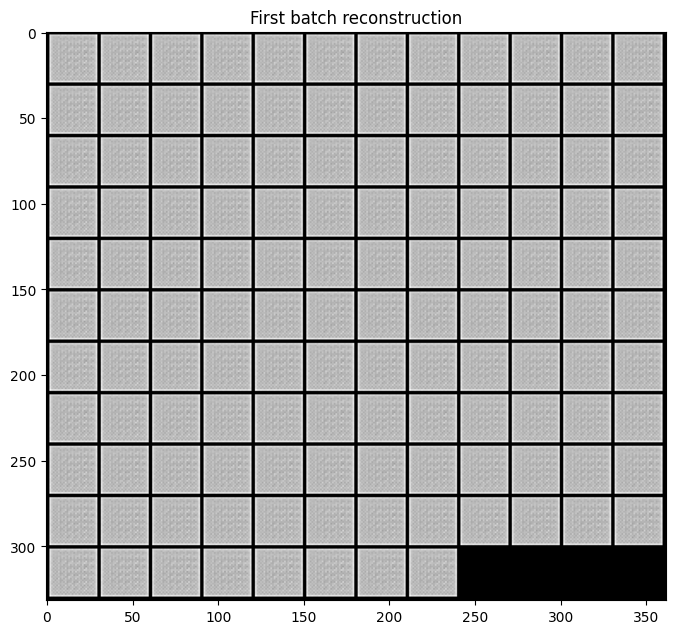

In [6]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


recon_x_grid = make_grid(recon_x, nrow=12).numpy()

plt.figure(figsize=(8, 8))
plt.title("First batch reconstruction")
plt.imshow(recon_x_grid[0], cmap="gray")

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
_ = vae.to(device)

In [9]:
import torch.optim as optim
from tqdm import tqdm

mse_fn = nn.MSELoss()
kld_loss_fn = lambda mu, logvar: 0.5 * (mu**2 + logvar.exp() - logvar - 1)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
n_epochs = 10


for epoch in range(n_epochs):
    epoch_loss = 0.0
    for step, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch + 1}/{n_epochs}")):
        x = batch[0].to(device)

        z = vae.encoder(x)
        z, mu, logvar = vae.reparameterize(z)
        recon_x = vae.decoder(z)

        loss = mse_fn(x, recon_x)

        recon_loss = mse_fn(x, recon_x)
        kld_loss = kld_loss_fn(mu, logvar).mean()
        loss = recon_loss + kld_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(x) / len(loader.dataset)

    log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

    print(log_string)


Epoch 1/10: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]


Loss at epoch 1: 0.227


Epoch 2/10: 100%|██████████| 469/469 [00:13<00:00, 33.95it/s]


Loss at epoch 2: 0.107


Epoch 3/10: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]


Loss at epoch 3: 0.086


Epoch 4/10: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]


Loss at epoch 4: 0.076


Epoch 5/10: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


Loss at epoch 5: 0.069


Epoch 6/10: 100%|██████████| 469/469 [00:14<00:00, 33.43it/s]


Loss at epoch 6: 0.063


Epoch 7/10: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]


Loss at epoch 7: 0.059


Epoch 8/10: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]


Loss at epoch 8: 0.055


Epoch 9/10: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]


Loss at epoch 9: 0.053


Epoch 10/10: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]

Loss at epoch 10: 0.051


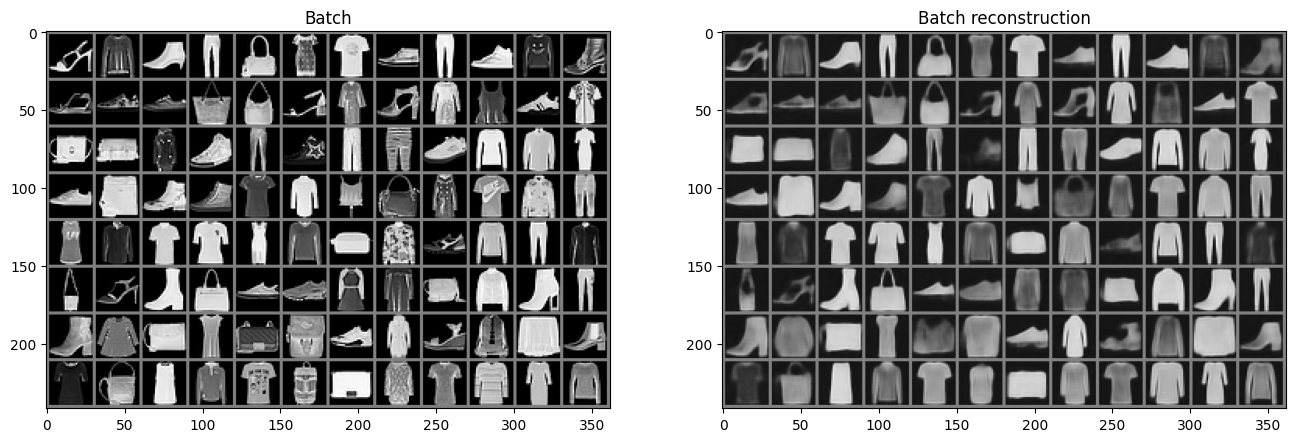

In [10]:
with torch.no_grad():    
    x = batch[0].to(device)
    recon_x = vae(x)
recon_x = recon_x.cpu()

x_grid = make_grid(x.cpu(), nrow=12).numpy()
recon_x_grid = make_grid(recon_x, nrow=12).numpy()

fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

axes[0].set_title("Batch")
axes[0].imshow(x_grid[0], cmap="gray")

axes[1].set_title("Batch reconstruction")
axes[1].imshow(recon_x_grid[0], cmap="gray")

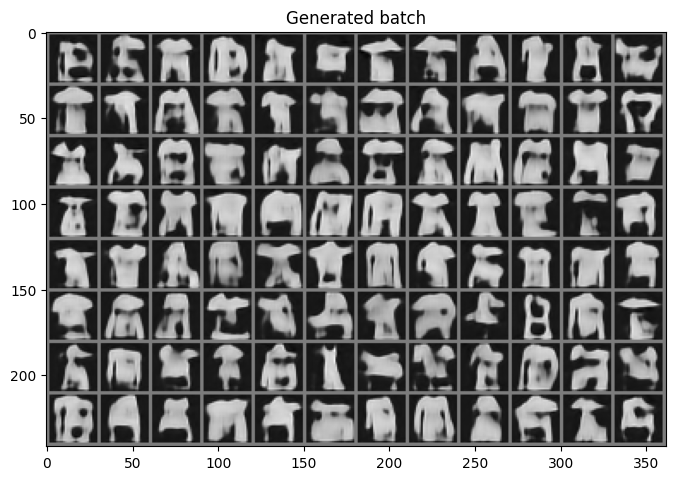

In [11]:
with torch.no_grad():    
    random_z = torch.rand_like(z).to(device)
    generated_x = vae.decoder(random_z)

generated_x = generated_x.cpu()
generated_x_grid = make_grid(generated_x, nrow=12).numpy()

plt.figure(figsize=(8, 8))
plt.title("Generated batch")
plt.imshow(generated_x_grid[0], cmap="gray")